In this notebook we will compare the MBR scores calculated with the monte-carlo estimates and those from the predictive model
We will try to analyse failure points and think about how to tackle those.



In [1]:
# Some setup code for imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [2]:

# First we will load the test set with the calculated scores.
dataset_loader = BayesRiskDatasetLoader("test", n_hypotheses=100, n_references=1000, sampling_method='ancestral')


In [3]:
dataset = dataset_loader.load(type="pandas")

In [4]:
# We will visualize the scores as



In [5]:
import numpy as np
def calculate_mbr_scores(entry, n_references=1000):
    scores = []
    count = np.sum(entry["utilities_count"])
    for hyp, util in zip(entry["hypotheses"], entry["utilities"]):
        score = np.sum(util* entry["utilities_count"])/count
        scores.append(score)
    return scores

In [6]:
entry_id=5
entry = dataset.data.iloc[entry_id]
scores = calculate_mbr_scores(entry)

print(scores)

[1.1133391144815832, 0.9755134445149451, 0.905233200730756, -1.3698183157444, -1.1949610184133053, 1.0327796646803618, 1.01902508867532, 0.7112088796794415, 0.7830700763016939, 0.8376556033492089, 0.5338141671177, 0.7649866837505251, 0.6780157202705741, 0.8344538183510304, 0.8344893747251481, -0.8230702860951423, 0.8618518640194088, 0.2451410574503243]


In [7]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_scores(hypotheses, scores, max_show=15):


    plt.rcdefaults()
    fig, ax = plt.subplots()

    
    y_pos = np.arange(len(hypotheses[:max_show]))
    
    

    ax.barh(y_pos, scores[:max_show],align='center')
    ax.set_yticks(y_pos, labels=hypotheses[:max_show])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('MBR scores')
    ax.set_title('plotting scores')

    plt.show()

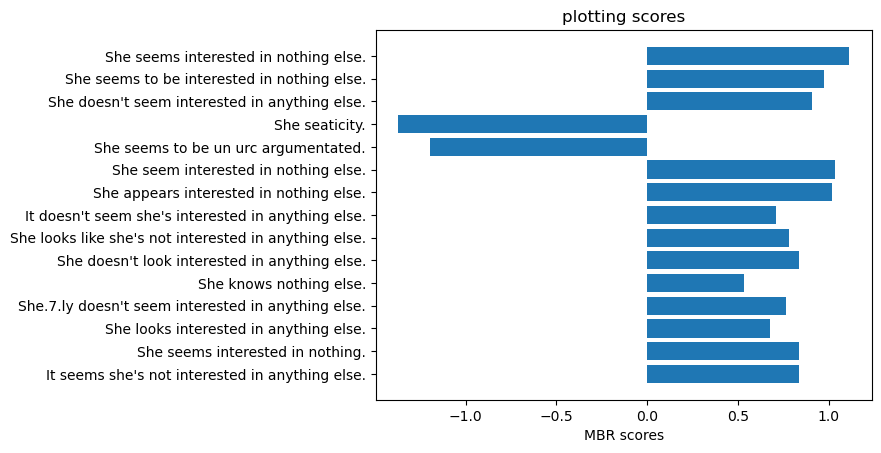

In [8]:
visualize_scores(entry["hypotheses"], scores)

In [9]:
### Next up we will read the trained model and calculate the score given by the heads
from models.pl_predictive.PLPredictiveModelFactory import PLPredictiveModelFactory
model, factory = PLPredictiveModelFactory.load("C:/Users/gerso/Desktop/results/hyperparam_search/train_model_tune_48132_00043_43_activation_function=silu,batch_size=128,dropout=0.53824,hidden_dim=512,lr=1.7855e-05,n_heads=8,n_q_2022-03-19_07-07-38/21/")

C:\Users\gerso\FBR\NMT/tatoeba-de-en/model
1.5300211951721644e-07
using a full model


In [10]:
from models.MBR_model.MBRModel import MBRModel
wrapped_model = MBRModel(model)

In [11]:
from tqdm import tqdm
all_scores = []
for i, row in tqdm(dataset.data.iterrows(), total=dataset.data.shape[0]):
    source = row["source"]
    hypotheses = list(row["hypotheses"])

    scores = wrapped_model.get_scores([source]* len(hypotheses), hypotheses)
    all_scores.append(scores)
    if i > 200:
        break

  4%|███▏                                                                           | 201/5000 [00:13<05:17, 15.13it/s]


In [12]:
print(all_scores[100])

[1.0192897, 1.0169771, 1.0665541, 1.2384794]


In [91]:

def clean(s):
    return s.replace('?', '')

def compare_scores(source, target, hypotheses, monte_carlo_scores, predicted_scores, max_show=15, labels=("Monte Carlo", "predicted"), colors=("b", "r"), save=False):
    
    # First we sort based on scores 1
    #First we show the 
    cleaned_source = clean(source)
    cleaned_target = clean(target)
    
    sorted_indices = np.argsort(-monte_carlo_scores)
    
    monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
    predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
    hypotheses_sorted = hypotheses[sorted_indices][:max_show]


    plt.rcdefaults()
    fig, ax = plt.subplots()
        
    
    y_pos = np.arange(len(hypotheses_sorted))
    
    width=0.35

    ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
    ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
    ax.set_yticks(y_pos, labels=hypotheses_sorted)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('scores')
    ax.set_title('MBR scores sorted on Monte-Carlo: \n {} \n {}'.format(source, target))
    ax.legend()
    
    fig.tight_layout()
    
    if save:
        plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "monte_carlo"), bbox_inches="tight")
    
    plt.show()
   
    
    sorted_indices = np.argsort(-predicted_scores)
    
    monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
    predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
    hypotheses_sorted = hypotheses[sorted_indices][:max_show]
    
    
    plt.rcdefaults()
    fig, ax = plt.subplots()
        
    
    y_pos = np.arange(len(hypotheses_sorted))
    
    width=0.35

    ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
    ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
    ax.set_yticks(y_pos, labels=hypotheses_sorted)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('scores')
    ax.set_title('MBR scores sorted on predicted: \n {} \n {}'.format(source, target))
    ax.legend()
    fig.tight_layout()
    if save:
        plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "predictive"))
    plt.show()

In [92]:
def compare_random_scores(data, predictive_scores, n_examples=5, seed=1):
    np.random.seed(seed)
    indices = np.random.choice(len(all_scores), size=n_examples)
    
    for i in indices:
        entry = data.iloc[i]
        compare_scores(entry["source"], entry["target"], np.array(entry["hypotheses"]),   np.array(calculate_mbr_scores(entry)), np.array(all_scores[i]), labels=["Monte carlo", 'predicted'], save=True)
    
    

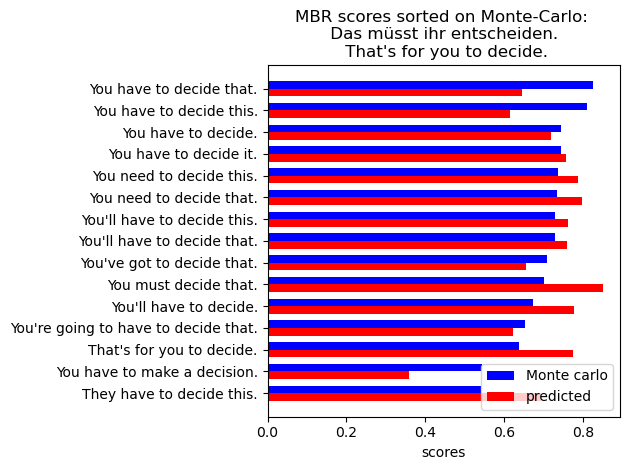

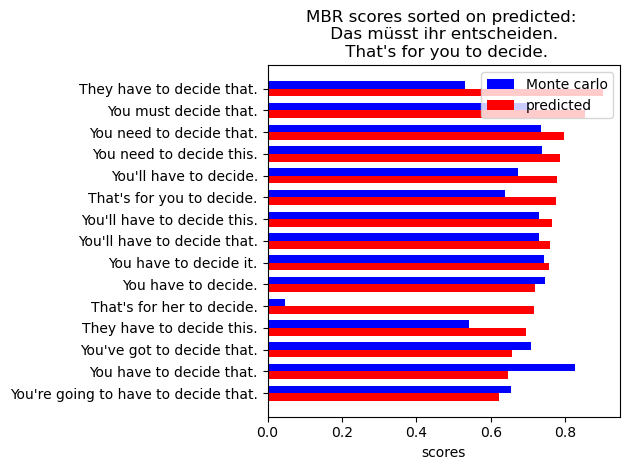

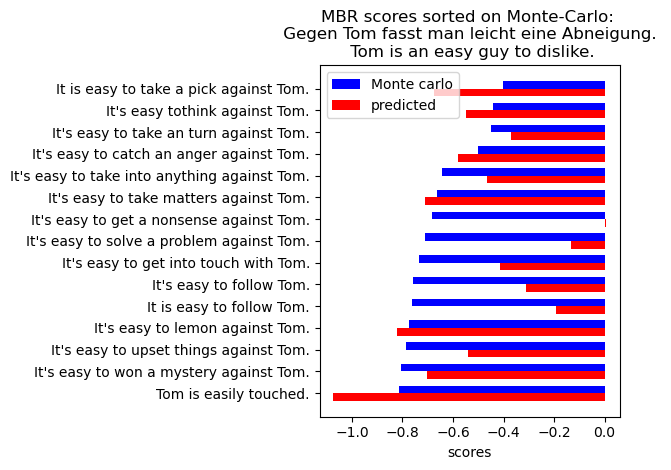

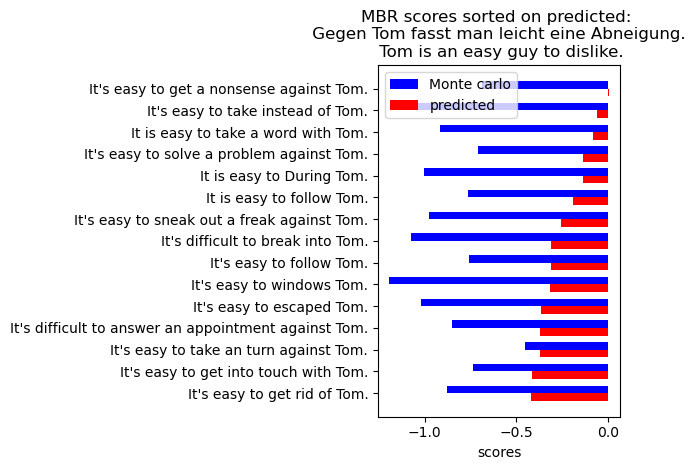

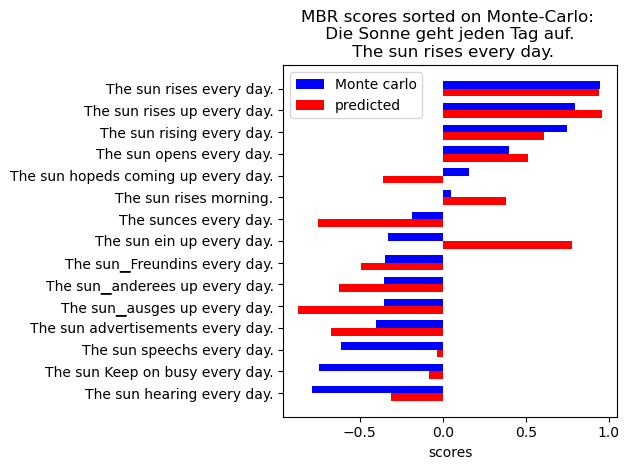

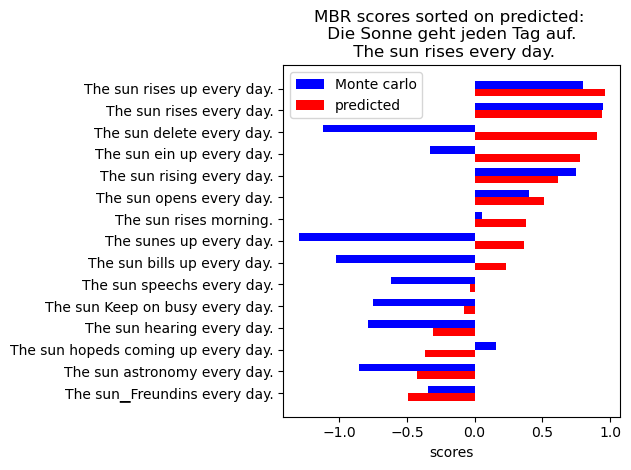

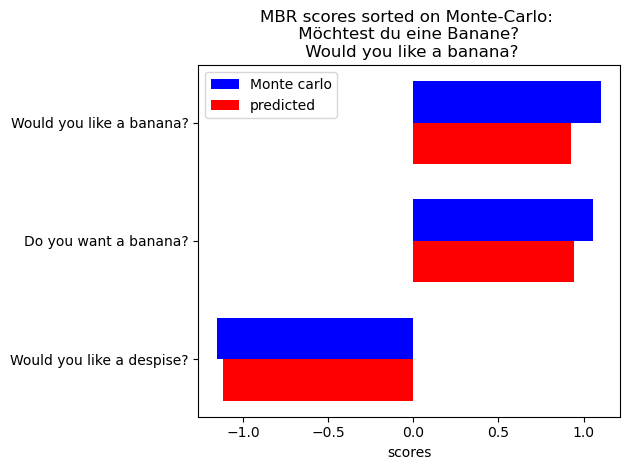

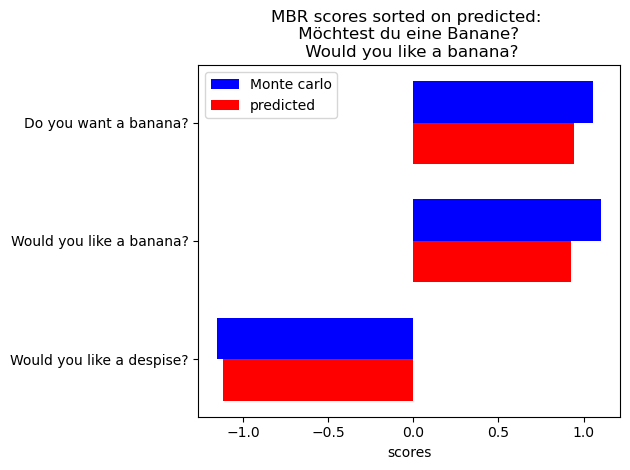

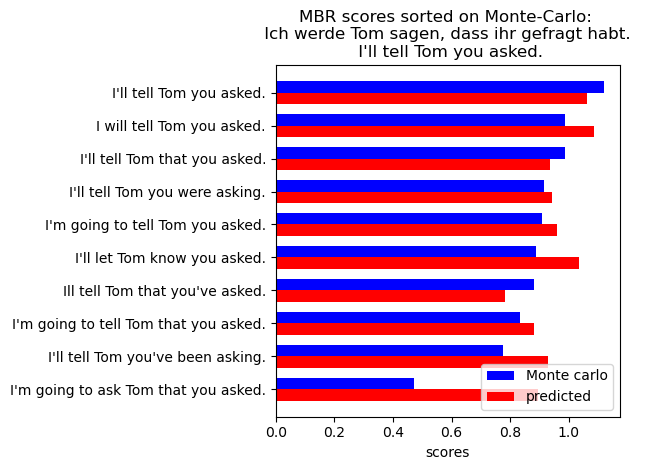

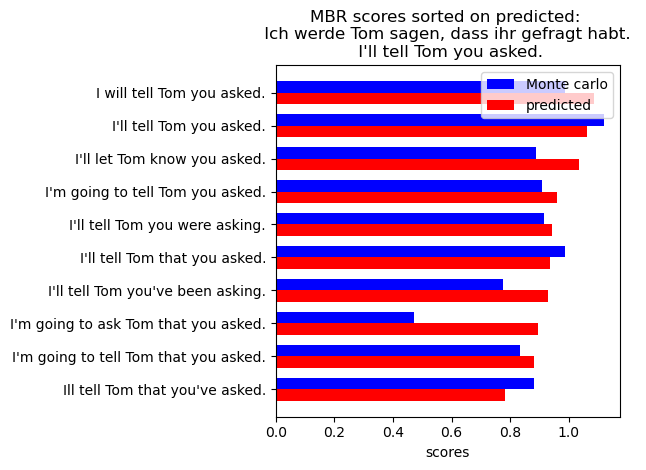

In [93]:
compare_random_scores(dataset.data, all_scores)